# **Sistema de Recomendação**

##### **Este é um projeto para o curso python da faculdade IESB realizado com dados privados disponibilizados pela empresa Netflix.**
##### **Fiz uma simulação de pedido por parte do CEO da netflix para ter uma motivação e escopo próximo da realidade de trabalho.**
##### **Nesse projeto realizei é o tipo de sistema de recomendacão Content Based (por conteúdo).**

## 1. Problema de Negócio

A Netflix para não perder espaço para seus concorrentes, pensa em investir em sistemas de recomendação com o objetivo de reter seus clientes e diminuir o número de churn.

## 2. Entendimento do Negócio

### Motivação
A netflix requisitou esse sistema ao perceber uma diminuição de conteúdos assistidos por seus usuários.

### Causa Raiz do Problema
Perda de interesse dos clientes e aumento de churn de clientes.

### Quem é o Stakeholder
o CEO da Netflix.


## 3. O projeto foi desenvolvido através da técnica CRISP-DM

- Versão END-TO_END da solução,
- Velocidade na entrega de valor,
- Mapeamento de todos os possíveis problems.

## 4.Resultado esperado

1. Um bom sistema de recomendação que fideliza o cliente
2. Clientes/usuários satisfeitos
3. Economia com manutenção de clientes
4. Diminuição de churn (também gera economia para a empresa)

##### ========================================================================================


# 0.0 Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import inflection
import datetime
import re

import heapq

import nltk

import pandas   as pd
import seaborn  as sns
import numpy    as np

from wordcloud                        import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus                      import stopwords
from nltk.tokenize                    import word_tokenize

from sklearn.feature_extraction.text  import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise         import linear_kernel
from sklearn.model_selection          import train_test_split

from matplotlib import pyplot     as plt
from scipy      import stats      as ss
from scipy      import stats

from sklearn    import ensemble   as en


## 0.1 Helper Functions

In [2]:
# Função do Gráfico de Correlação

def cramer_v( x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
   
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )  

def cramers_v_df(categorical_features):

    rows= []

    for var1 in categorical_features:

        col = []

        for var2 in categorical_features:
            cramers =cramer_v(categorical_features[var1], categorical_features[var2]) 
            col.append(round(cramers,3)) 

        rows.append(col)

    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns=categorical_features.columns, index=categorical_features.columns)

    return df

## 0.2 Loading Data

In [3]:
df_raw = pd.read_csv("/Users/raquelrocha/Documents/ProjetosIESB/SistemadeRecomendacao/dados/ViewingActivity.csv",low_memory = False)


In [4]:
# Divide into X and y
x_raw = df_raw.drop("Title", axis=1)
y_raw = df_raw["Title"].copy()

# Split into Train & Test
x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.15, random_state=42)

# Concatenate X and y of Train dataset , deixa test de fora desses arquivos
df1 = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)


# 1.0 Descrição dos Dados

##### Nesse passo inicial, pretendendo obter as seguintes informações sobre as variáveis:
- número de linhas e colunas;
- quantidade de linhas NaN/Null;
- tipo dos dados;
- nome das colunas,
- e quantidade únicas de cada elementos por coluna

In [5]:
df1 = df_raw.copy()

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7460 entries, 0 to 7459
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Profile Name             7460 non-null   object
 1   Start Time               7460 non-null   object
 2   Duration                 7460 non-null   object
 3   Attributes               1860 non-null   object
 4   Title                    7460 non-null   object
 5   Supplemental Video Type  222 non-null    object
 6   Device Type              7460 non-null   object
 7   Bookmark                 7460 non-null   object
 8   Latest Bookmark          7460 non-null   object
 9   Country                  7460 non-null   object
dtypes: object(10)
memory usage: 582.9+ KB


In [7]:
df1.describe().T

,count,unique,top,freq
Profile Name,7460,3,Raquel,5944
Start Time,7460,7458,2021-08-30 18:32:23,2
Duration,7460,2888,00:00:01,139
Attributes,1860,5,Autoplayed: user action: Unspecified;,1199
Title,7460,4551,NullCompleteVideo,29
Supplemental Video Type,222,4,HOOK,121
Device Type,7460,7,Samsung 2014 MStar DTV,5581
Bookmark,7460,2846,00:21:53,80
Latest Bookmark,7460,2053,Not latest view,2644
Country,7460,1,BR (Brazil),7460


## 1.1 Rename Columns

In [8]:
cols_old = ["Profile Name", "Start Time", "Duration", "Attributes", "Title",
            "Supplemental Video Type", "Device Type", "Bookmark", "Latest Bookmark",
            "Country"]
#response_y
#Colocar em letra minúscula e snakecase
snakecase = lambda x: inflection.underscore (x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

cols_new

['profile name',
 'start time',
 'duration',
 'attributes',
 'title',
 'supplemental video type',
 'device type',
 'bookmark',
 'latest bookmark',
 'country']

In [9]:
df1.head()

,profile name,start time,duration,attributes,title,supplemental video type,device type,bookmark,latest bookmark,country
0,Kids,2022-08-27 17:08:40,00:11:49,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,00:11:49,00:11:49,BR (Brazil)
1,Kids,2022-08-27 17:05:32,00:02:35,Autoplayed: user action: User_Interaction;,"Patrulha Canina: Temporada 6: Super filhotes, ...",NaN,Samsung 2014 MStar DTV,00:12:17,00:12:17,BR (Brazil)
2,Kids,2022-08-27 16:53:22,00:12:05,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,00:12:09,00:12:09,BR (Brazil)
3,Kids,2022-08-27 16:30:08,00:23:09,NaN,Patrulha Canina: Temporada 6: Os filhotes salv...,NaN,Samsung 2014 MStar DTV,00:23:09,00:23:09,BR (Brazil)
4,Kids,2022-08-27 16:26:38,00:03:26,NaN,"Patrulha Canina: Temporada 6: Super filhotes, ...",NaN,Samsung 2014 MStar DTV,00:03:26,00:03:26,BR (Brazil)


## 1.2 Data Dimensions

In [10]:
print ("Number of Rows:{}".format(df1.shape[0]))
print ("Number of Cols:{}".format(df1.shape[1]))

Number of Rows:7460
Number of Cols:10


## 1.3 Data Types

In [11]:
df1.dtypes

profile name               object
start time                 object
duration                   object
attributes                 object
title                      object
supplemental video type    object
device type                object
bookmark                   object
latest bookmark            object
country                    object
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()

profile name                  0
start time                    0
duration                      0
attributes                 5600
title                         0
supplemental video type    7238
device type                   0
bookmark                      0
latest bookmark               0
country                       0
dtype: int64

## 1.5 Fillout NA

##### limpeza de NaN foi feita em passos posteriores

## 1.6 Change Types (Estatística Descritiva)

In [13]:
df1["start time"] = pd.to_datetime(df1["start time"])
df1["duration"] = pd.to_datetime(df1["duration"])
df1["bookmark"] = pd.to_datetime(df1["bookmark"])


In [14]:
df1["duration_time"] = df1["duration"].dt.strftime("%H:%M:%S")
df1["start_time"] = df1["start time"].dt.strftime("%d-%m-%Y")


In [15]:
df1["duration_time"] = pd.to_datetime(df1["duration_time"])
df1["start_time"] = pd.to_datetime(df1["start_time"])

## 1.7 Descriptive Statistical

In [16]:
#numérico
num_attributes = df1.select_dtypes(include=["int64", "float64"])
#categórico
cat_attributes = df1.select_dtypes(exclude=["int64", "float64","datetime64[ns]"])


In [17]:
cat_attributes.sample(5)

,profile name,attributes,title,supplemental video type,device type,latest bookmark,country
103,Raquel,Autoplayed: user action: None;,Temporada 1 (Clipe): BASTARD!!,HOOK,Samsung 2014 MStar DTV,Not latest view,BR (Brazil)
1809,Raquel,Autoplayed: user action: Unspecified;,Disque Amiga para Matar: Temporada 1: Eu consi...,NaN,Samsung 2014 MStar DTV,00:25:57,BR (Brazil)
5326,Raquel,NaN,Dilbert: Temporada 2: Episódio 7 (Episódio 7),NaN,Samsung 2014 MStar DTV,00:22:02,BR (Brazil)
2241,Raquel,NaN,O Mundo Sombrio de Sabrina: Parte 1: Capítulo ...,NaN,Samsung 2014 MStar DTV,00:55:51,BR (Brazil)
3314,Raquel,Autoplayed: user action: Unspecified;,Legion: Temporada 1: Capítulo 1 (Episódio 1),NaN,Samsung 2014 MStar DTV,01:05:39,BR (Brazil)


### 1.7.1 Numerical Attributes

In [18]:
# Não tenho dados sufucientes para fazer essa etapa

### 1.7.2 Categorical Attributes

In [19]:
# níveis que cada variável categórica tem
cat_attributes.apply(lambda x: x.unique().shape[0])

profile name                  3
attributes                    6
title                      4551
supplemental video type       5
device type                   7
latest bookmark            2053
country                       1
dtype: int64

In [20]:
titulo = df1["title"].value_counts()
titulo

NullCompleteVideo                                                          29
Imperador                                                                  10
Sense8: Temporada 1: Ressonância límbica (Episódio 1)                       9
Family Guy: Temporada 9: And Then There Were Fewer Parte 1 (Episódio 1)     9
Mad Men: Temporada 7: Dia de trabalho (Episódio 2)                          9
                                                                           ..
Grace and Frankie: Temporada 4: Os ratos (Episódio 12)                      1
Grace and Frankie: Temporada 4: A banheira (Episódio 11)                    1
Grace and Frankie: Temporada 4: O joelho (Episódio 9)                       1
Grace and Frankie: Temporada 4: O confinamento (Episódio 8)                 1
As aventuras de Peabody e Sherman                                           1
Name: title, Length: 4551, dtype: int64

### Esse gráfico de distribuição mostra qual o tempo dos filmes assistidos pelo usuário
Nesse histograma observamos que o usuário tem uma frequência maior de videos assistidos com a duração de 30min. Videos com duração de 2 horas acabam por ser possíveis outliers.

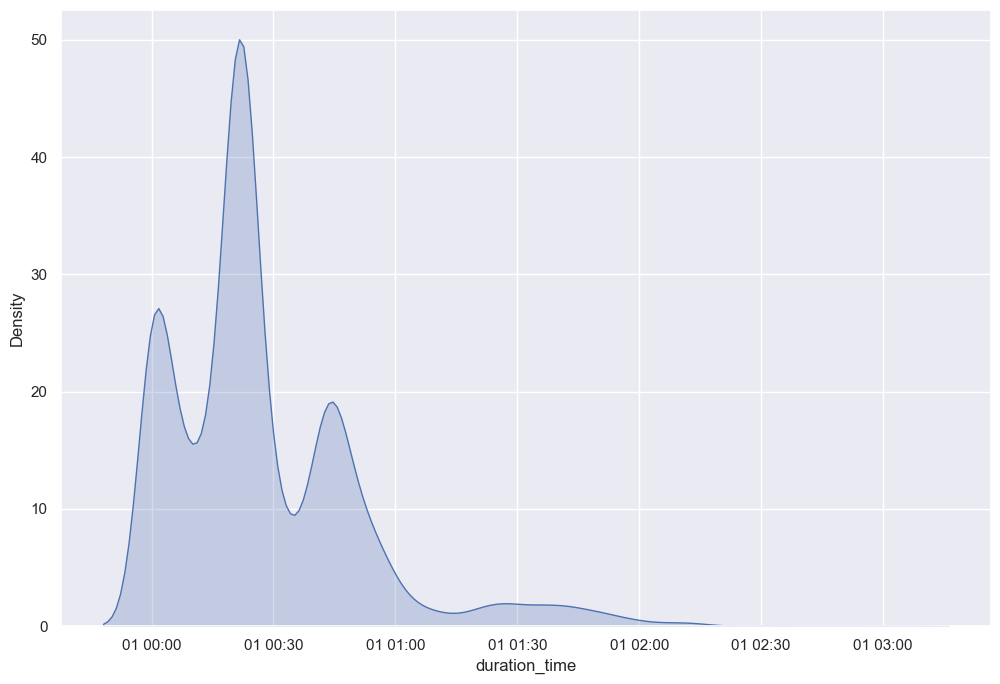

In [21]:
sns.set(style="darkgrid")
plt.figure(figsize=(12,8))
ax=sns.kdeplot(data=df1["duration_time"], fill=True)

### Esse gráfico de linhas mostra o comportamento do usuário entre os anos 2015 e 2022
Observamos quedas consideráveis de videos assistidos ao londo da linha do tempo demonstrada, mas dois anos em específico chamam a atenção:
- 2016, ano de lançamento da plataforma Prime video no Brasil
- 2019, ano de lançamento da plataforma de streaming da Disney.

De 2020 à 2022, o número de videos assistidos tem se mostrado mais uniforme, apesar de ainda ter momentos de quedas de views entre esses anos.

<AxesSubplot:xlabel='start_time'>

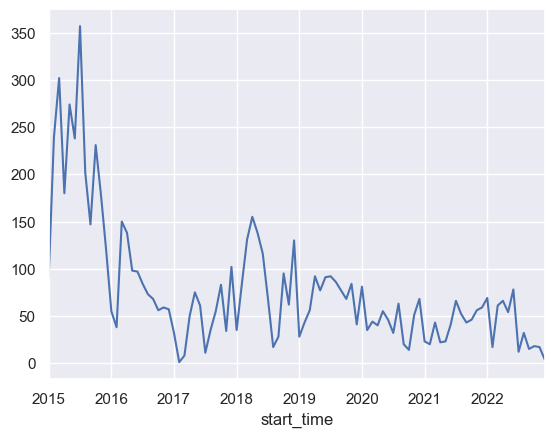

In [22]:
data = df1["start_time"].groupby(pd.to_datetime(df1["start_time"], infer_datetime_format=True).dt.to_period("M")).agg("count")
data.plot()


# 2.0 Feature Engineering

##### Apesar do modelo de recomendação entregue constar tanto filmes e séries nas recomendações, a separação dessas informações, em uma coluna criada, facilita entendermos e melhorarmos o modelo em próximos ciclos.

In [23]:
df2 = df1.copy()

In [24]:
#criando nova coluna para ter separação do que é filme e o que é serie
df2["categoria"]= df2["title"].apply( lambda x: "serie" if "Temporada" in x else "filme")


In [25]:
#Verificando
df2[["title", "categoria"]]

,title,categoria
0,Patrulha Canina: Temporada 6: Os filhotes salv...,serie
1,"Patrulha Canina: Temporada 6: Super filhotes, ...",serie
2,Patrulha Canina: Temporada 6: Os filhotes salv...,serie
3,Patrulha Canina: Temporada 6: Os filhotes salv...,serie
4,"Patrulha Canina: Temporada 6: Super filhotes, ...",serie
...,...,...
7455,Friends: Temporada 6: Aquele com a negação do ...,serie
7456,Friends: Temporada 6: Aquele em que Ross abraç...,serie
7457,Friends: Temporada 6: Aquele depois de Vegas (...,serie
7458,Friends: Temporada 6: Aquele depois de Vegas (...,serie


# 3.0 Filtragem de Variáveis

##### Filtrei a variável "profile name" para apenas ter os dados de usuário Visitas e Raquel, além de retirar algumas linhas da coluna "supplemental video type", para excluir do dataset as informações de videos que não são videos ou filmes.

In [26]:
df3 = df2.copy()

In [27]:
df3["supplemental video type"].unique()

array([nan, 'HOOK', 'TRAILER', 'RECAP', 'TEASER_TRAILER'], dtype=object)

In [28]:
# retirar profile kids
# retirar linhas com titulos trailler, hook, recap, teaser do dataset

df3.drop(df3.loc[df3["profile name"]=="Kids"].index, inplace=True)
df3.drop(df3.loc[df3["supplemental video type"]=="RECAP"].index, inplace=True)
df3.drop(df3.loc[df3["supplemental video type"]=="TRAILER"].index, inplace=True)
df3.drop(df3.loc[df3["supplemental video type"]=="HOOK"].index, inplace=True)
df3.drop(df3.loc[df3["supplemental video type"]=="TEASER_TRAILER"].index, inplace=True)


In [29]:
df3.loc[df3["categoria"]=="filme"].count()

profile name               1579
start time                 1579
duration                   1579
attributes                  519
title                      1579
supplemental video type       0
device type                1579
bookmark                   1579
latest bookmark            1579
country                    1579
duration_time              1579
start_time                 1579
categoria                  1579
dtype: int64

In [30]:
df3.loc[df3["categoria"]=="serie"].count()

profile name               5615
start time                 5615
duration                   5615
attributes                 1128
title                      5615
supplemental video type       0
device type                5615
bookmark                   5615
latest bookmark            5615
country                    5615
duration_time              5615
start_time                 5615
categoria                  5615
dtype: int64

In [31]:
#Mudando o nome do atributo visitas
df3["profile name"] = df3["profile name"].replace(["Visitas"],"Raquel")

In [32]:
#Extraindo as informações descritivas da coluna title para uma nova coluna descricao
df3['descricao']= df3['title'].str.extract('(:.?.+)', expand = True)
df3['descricao']

47                : Temporada 2: 2022-08-25 (Episódio 13)
48                : Temporada 2: 2022-08-18 (Episódio 12)
49                : Temporada 2: 2022-08-18 (Episódio 12)
52      : Temporada 1: Sonho de mil gatos/Calíope (Epi...
54                : Temporada 2: 2022-08-11 (Episódio 11)
                              ...                        
7455    : Temporada 6: Aquele com a negação do Ross (E...
7456    : Temporada 6: Aquele em que Ross abraça Rache...
7457    : Temporada 6: Aquele depois de Vegas (Episódi...
7458    : Temporada 6: Aquele depois de Vegas (Episódi...
7459                                                  NaN
Name: descricao, Length: 7194, dtype: object

In [33]:
# Deletar a descrição do title
df3["title"] = df3["title"].str.split(":", expand=True)[0]

In [34]:
df3.dtypes

profile name                       object
start time                 datetime64[ns]
duration                   datetime64[ns]
attributes                         object
title                              object
supplemental video type            object
device type                        object
bookmark                   datetime64[ns]
latest bookmark                    object
country                            object
duration_time              datetime64[ns]
start_time                 datetime64[ns]
categoria                          object
descricao                          object
dtype: object

In [35]:
#retirado os ":" da coluna title
#df3["descricao"] = df3["descricao"].apply(lambda x: x.split(":")[1])

In [36]:
df3.head()

,profile name,start time,duration,attributes,title,supplemental video type,device type,bookmark,latest bookmark,country,duration_time,start_time,categoria,descricao
47,Raquel,2022-09-04 22:06:00,2022-12-01 00:06:13,Autoplayed: user action: Unspecified;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 00:06:13,00:06:13,BR (Brazil),2022-12-01 00:06:13,2022-04-09,serie,: Temporada 2: 2022-08-25 (Episódio 13)
48,Raquel,2022-09-04 20:51:34,2022-12-01 00:46:54,NaN,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 01:14:17,01:14:17,BR (Brazil),2022-12-01 00:46:54,2022-04-09,serie,: Temporada 2: 2022-08-18 (Episódio 12)
49,Raquel,2022-09-04 19:20:39,2022-12-01 00:27:26,Autoplayed: user action: User_Interaction;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 00:27:26,Not latest view,BR (Brazil),2022-12-01 00:27:26,2022-04-09,serie,: Temporada 2: 2022-08-18 (Episódio 12)
52,Raquel,2022-08-21 19:42:50,2022-12-01 00:32:01,NaN,Sandman,NaN,Samsung 2014 MStar DTV,2022-12-01 00:48:07,00:48:07,BR (Brazil),2022-12-01 00:32:01,2022-08-21,serie,: Temporada 1: Sonho de mil gatos/Calíope (Epi...
54,Raquel,2022-08-14 13:17:25,2022-12-01 01:12:09,Autoplayed: user action: User_Interaction;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 01:12:09,01:12:09,BR (Brazil),2022-12-01 01:12:09,2022-08-14,serie,: Temporada 2: 2022-08-11 (Episódio 11)


In [37]:
df3.isna().sum()

profile name                  0
start time                    0
duration                      0
attributes                 5547
title                         0
supplemental video type    7194
device type                   0
bookmark                      0
latest bookmark               0
country                       0
duration_time                 0
start_time                    0
categoria                     0
descricao                   876
dtype: int64

In [38]:
#preenchendo as linhas faltantes
df3["descricao"].fillna("$", inplace = True)

In [39]:
df3.drop_duplicates()

,profile name,start time,duration,attributes,title,supplemental video type,device type,bookmark,latest bookmark,country,duration_time,start_time,categoria,descricao
47,Raquel,2022-09-04 22:06:00,2022-12-01 00:06:13,Autoplayed: user action: Unspecified;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 00:06:13,00:06:13,BR (Brazil),2022-12-01 00:06:13,2022-04-09,serie,: Temporada 2: 2022-08-25 (Episódio 13)
48,Raquel,2022-09-04 20:51:34,2022-12-01 00:46:54,NaN,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 01:14:17,01:14:17,BR (Brazil),2022-12-01 00:46:54,2022-04-09,serie,: Temporada 2: 2022-08-18 (Episódio 12)
49,Raquel,2022-09-04 19:20:39,2022-12-01 00:27:26,Autoplayed: user action: User_Interaction;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 00:27:26,Not latest view,BR (Brazil),2022-12-01 00:27:26,2022-04-09,serie,: Temporada 2: 2022-08-18 (Episódio 12)
52,Raquel,2022-08-21 19:42:50,2022-12-01 00:32:01,NaN,Sandman,NaN,Samsung 2014 MStar DTV,2022-12-01 00:48:07,00:48:07,BR (Brazil),2022-12-01 00:32:01,2022-08-21,serie,: Temporada 1: Sonho de mil gatos/Calíope (Epi...
54,Raquel,2022-08-14 13:17:25,2022-12-01 01:12:09,Autoplayed: user action: User_Interaction;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 01:12:09,01:12:09,BR (Brazil),2022-12-01 01:12:09,2022-08-14,serie,: Temporada 2: 2022-08-11 (Episódio 11)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,Raquel,2015-04-26 20:08:20,2022-12-01 00:21:54,NaN,Friends,NaN,Samsung 2014 MStar DTV,2022-12-01 00:21:54,Not latest view,BR (Brazil),2022-12-01 00:21:54,2015-04-26,serie,: Temporada 6: Aquele com a negação do Ross (E...
7456,Raquel,2015-04-26 19:46:01,2022-12-01 00:21:53,NaN,Friends,NaN,Samsung 2014 MStar DTV,2022-12-01 00:21:53,Not latest view,BR (Brazil),2022-12-01 00:21:53,2015-04-26,serie,: Temporada 6: Aquele em que Ross abraça Rache...
7457,Raquel,2015-04-26 19:23:30,2022-12-01 00:22:06,NaN,Friends,NaN,Samsung 2014 MStar DTV,2022-12-01 00:22:06,Not latest view,BR (Brazil),2022-12-01 00:22:06,2015-04-26,serie,: Temporada 6: Aquele depois de Vegas (Episódi...
7458,Raquel,2015-04-26 19:23:12,2022-12-01 00:00:09,NaN,Friends,NaN,Samsung 2014 MStar DTV,2022-12-01 00:00:09,Not latest view,BR (Brazil),2022-12-01 00:00:09,2015-04-26,serie,: Temporada 6: Aquele depois de Vegas (Episódi...


In [40]:
#tirar duplicados na coluna title e recolocar em uma nova coluna do dataframe
df3["title_2"] = df3["title"].drop_duplicates()

In [41]:
df3.head()

,profile name,start time,duration,attributes,title,supplemental video type,device type,bookmark,latest bookmark,country,duration_time,start_time,categoria,descricao,title_2
47,Raquel,2022-09-04 22:06:00,2022-12-01 00:06:13,Autoplayed: user action: Unspecified;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 00:06:13,00:06:13,BR (Brazil),2022-12-01 00:06:13,2022-04-09,serie,: Temporada 2: 2022-08-25 (Episódio 13),Casais em Crise
48,Raquel,2022-09-04 20:51:34,2022-12-01 00:46:54,NaN,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 01:14:17,01:14:17,BR (Brazil),2022-12-01 00:46:54,2022-04-09,serie,: Temporada 2: 2022-08-18 (Episódio 12),NaN
49,Raquel,2022-09-04 19:20:39,2022-12-01 00:27:26,Autoplayed: user action: User_Interaction;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 00:27:26,Not latest view,BR (Brazil),2022-12-01 00:27:26,2022-04-09,serie,: Temporada 2: 2022-08-18 (Episódio 12),NaN
52,Raquel,2022-08-21 19:42:50,2022-12-01 00:32:01,NaN,Sandman,NaN,Samsung 2014 MStar DTV,2022-12-01 00:48:07,00:48:07,BR (Brazil),2022-12-01 00:32:01,2022-08-21,serie,: Temporada 1: Sonho de mil gatos/Calíope (Epi...,Sandman
54,Raquel,2022-08-14 13:17:25,2022-12-01 01:12:09,Autoplayed: user action: User_Interaction;,Casais em Crise,NaN,Samsung 2014 MStar DTV,2022-12-01 01:12:09,01:12:09,BR (Brazil),2022-12-01 01:12:09,2022-08-14,serie,: Temporada 2: 2022-08-11 (Episódio 11),NaN


In [42]:
#deletar coluna
df3.drop(["title"], axis=1, inplace=True)

In [43]:
#verificando dados nulos
df3.isna().sum()

profile name                  0
start time                    0
duration                      0
attributes                 5547
supplemental video type    7194
device type                   0
bookmark                      0
latest bookmark               0
country                       0
duration_time                 0
start_time                    0
categoria                     0
descricao                     0
title_2                    6428
dtype: int64

In [44]:
#reiniciando o index do DataFrame
df3.reset_index(drop=True, inplace=True)

In [45]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7194 entries, 0 to 7193
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   profile name             7194 non-null   object        
 1   start time               7194 non-null   datetime64[ns]
 2   duration                 7194 non-null   datetime64[ns]
 3   attributes               1647 non-null   object        
 4   supplemental video type  0 non-null      object        
 5   device type              7194 non-null   object        
 6   bookmark                 7194 non-null   datetime64[ns]
 7   latest bookmark          7194 non-null   object        
 8   country                  7194 non-null   object        
 9   duration_time            7194 non-null   datetime64[ns]
 10  start_time               7194 non-null   datetime64[ns]
 11  categoria                7194 non-null   object        
 12  descricao                7194 non-

In [46]:
df3.loc[df3["descricao"]=="$"].count()

profile name               876
start time                 876
duration                   876
attributes                 251
supplemental video type      0
device type                876
bookmark                   876
latest bookmark            876
country                    876
duration_time              876
start_time                 876
categoria                  876
descricao                  876
title_2                    476
dtype: int64

## 3.1 Seleção das colunas

In [47]:
#deletar coluna
df3.drop(["start time", "duration", "attributes", "supplemental video type"], axis=1, inplace=True)


In [48]:
#deletar na
df3.dropna (axis = 0, inplace = True)

In [49]:
df3.reset_index(drop=True, inplace=True)

In [50]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   profile name     766 non-null    object        
 1   device type      766 non-null    object        
 2   bookmark         766 non-null    datetime64[ns]
 3   latest bookmark  766 non-null    object        
 4   country          766 non-null    object        
 5   duration_time    766 non-null    datetime64[ns]
 6   start_time       766 non-null    datetime64[ns]
 7   categoria        766 non-null    object        
 8   descricao        766 non-null    object        
 9   title_2          766 non-null    object        
dtypes: datetime64[ns](3), object(7)
memory usage: 60.0+ KB


In [51]:
# Rodar apenas para exportar o dataframe e preencher a descrição no excel
#df3.to_excel(r'/Users/raquelrocha/Documents/ProjetosIESB/SistemadeRecomendacao/dados/netflix_descricao.xlsx', index = False)


In [52]:
df_IMDB = pd.read_csv("/Users/raquelrocha/Documents/ProjetosIESB/SistemadeRecomendacao/dados/IMDb_movies.csv",low_memory = False)


In [53]:
df_imdb2=df_IMDB.copy()

In [ ]:
df_imdb2.columns

In [ ]:
# Renomeando a coluna para ter a coluna chave que irá ligar os dois dataframes
df3.rename(columns={'title_2': 'title'}, inplace = True)

In [ ]:
#ver se renomeou
df3.head()

In [ ]:
df3.info()

In [ ]:
# preparando dataset para fazer o merge, pela chave title, no dataset original fornecido pelo netflix
df3_imdb = pd.DataFrame (df_imdb2[["description","title"]], columns=["description","title"])
df3_imdb

In [ ]:
# Merge
df3 = pd.merge(df3,df3_imdb, on="title", how="left")
df3

In [ ]:
#ver se manteve o numero 766 rows
df3.info()

In [ ]:
df3.nunique()

In [ ]:
#ver quantos NA existem
df3.isna().sum()

In [ ]:
#apagar dados duplicados
df3["title"] = df3["title"].drop_duplicates()

In [ ]:
#ver se manteve o numero 766 rows
df3.info()

In [ ]:
df3["description"].fillna(value= df3["descricao"], inplace=True)

In [ ]:
#ver se manteve o numero 766 rows
df3.info()

In [ ]:
#fiz apenas para colocar a descrição no excel (Não Rodar)
#df3.to_excel(r'/Users/raquelrocha/Documents/ProjetosIESB/SistemadeRecomendacao/dados/netflix_descricao_idmb.xlsx', index = False)


In [ ]:
#apagar dados NA'S
df3=df3.dropna()

In [ ]:
#ver se manteve o numero 766 rows
df3.info()

In [ ]:
df3.head()

In [ ]:
df3.tail()

In [ ]:
df3.isna().sum()

In [ ]:
#Ver quantos dados sem descricão ainda ficaram
df3.loc[df3["description"]=="$"].count()

# 4.0 EDA - Análise Exploratória dos Dados

##### Pela falta de dados, a análise exploratória se limitou em uma análise textual por meio de nuvens de palavras da coluna "titulo" e observar as correlações entre as variáveis categóricas

In [54]:
#Dados gerados e modificados no final do passo 3.1
df31 = pd.read_csv("/Users/raquelrocha/Documents/ProjetosIESB/SistemadeRecomendacao/dados/netflix_descricao_final.csv",encoding="ISO-8859-1", sep=";")


In [55]:
df4 = df31.copy()

In [56]:
df4.head()

,profile name,device type,bookmark,latest bookmark,country,duration_time,start_time,categoria,descricao,title_2
0,Raquel,Samsung 2014 MStar DTV,2022-10-31 00:06:13,00:06:13,BR (Brazil),2022-10-31 00:06:13,2022-04-09 00:00:00,serie,4 casais que estão passando por problemas no r...,Casais em Crise
1,Raquel,Samsung 2014 MStar DTV,2022-10-31 00:48:07,00:48:07,BR (Brazil),2022-10-31 00:32:01,2022-08-21 00:00:00,serie,"Após anos aprisionado, Morpheus, o Rei dos Son...",Sandman
2,Raquel,Samsung 2014 MStar DTV,2022-10-31 00:01:40,00:01:40,BR (Brazil),2022-10-31 00:01:40,2022-12-08 00:00:00,filme,"Durante a Primeira Guerra Mundial, dois jovens...",1917
3,Raquel,Samsung 2014 MStar DTV,2022-10-31 01:38:05,01:38:05,BR (Brazil),2022-10-31 01:39:13,2022-08-08 00:00:00,filme,"Em uma penitenciária de última geração, um det...",Spiderhead
4,Raquel,Samsung 2014 MStar DTV,2022-10-31 00:00:02,00:00:02,BR (Brazil),2022-10-31 00:00:02,2022-08-08 00:00:00,serie,Décadas depois da competição que mudou suas vi...,Cobra Kai


Text(0.5, 1.0, 'Palavras mais populares na descrição da Netflix')

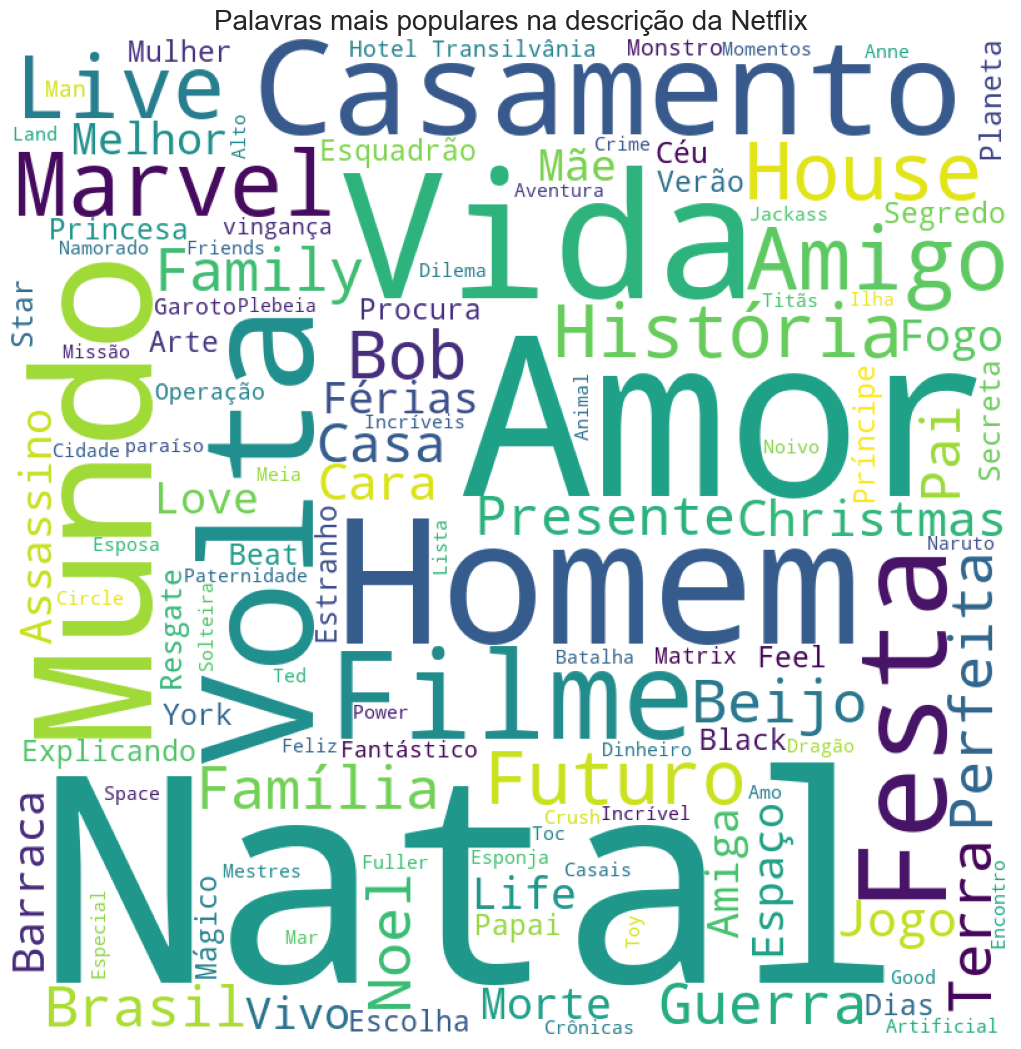

In [57]:
#wordcloud para entender visualmente as palavras que mais aparecem na coluna descricao
stopwords = ["a","acerca","adeus","agora","ainda","alem","algmas","algo","algumas","alguns","ali","além","ambas","ambos","ano","anos","antes","ao","aonde","aos","apenas","apoio","apontar","apos","após","aquela","aquelas","aquele","aqueles","aqui","aquilo","as","assim","através","atrás","até","aí","baixo","bastante","bem","boa","boas","bom","bons","breve","cada","caminho","catorze","cedo","cento","certamente","certeza","cima","cinco","coisa","com","como","comprido","conhecido","conselho","contra","contudo","corrente","cuja","cujas","cujo","cujos","custa","cá","da","daquela","daquelas","daquele","daqueles","dar","das","de","debaixo","dela","delas","dele","deles","demais","dentro","depois","desde","desligado","dessa","dessas","desse","desses","desta","destas","deste","destes","deve","devem","deverá","dez","dezanove","dezasseis","dezassete","dezoito","dia","diante","direita","dispoe","dispoem","diversa","diversas","diversos","diz","dizem","dizer","do","dois","dos","doze","duas","durante","dá","dão","dúvida","e","ela","elas","ele","eles","em","embora","enquanto","entao","entre","então","era","eram","essa","essas","esse","esses","esta","estado","estamos","estar","estará","estas","estava","estavam","este","esteja","estejam","estejamos","estes","esteve","estive","estivemos","estiver","estivera","estiveram","estiverem","estivermos","estivesse","estivessem","estiveste","estivestes","estivéramos","estivéssemos","estou","está","estás","estávamos","estão","eu","exemplo","falta","fará","favor","faz","fazeis","fazem","fazemos","fazer","fazes","fazia","faço","fez","fim","final","foi","fomos","for","fora","foram","forem","forma","formos","fosse","fossem","foste","fostes","fui","fôramos","fôssemos","geral","grande","grandes","grupo","ha","haja","hajam","hajamos","havemos","havia","hei","hoje","hora","horas","houve","houvemos","houver","houvera","houveram","houverei","houverem","houveremos","houveria","houveriam","houvermos","houverá","houverão","houveríamos","houvesse","houvessem","houvéramos","houvéssemos","há","hão","iniciar","inicio","ir","irá","isso","ista","iste","isto","já","lado","lhe","lhes","ligado","local","logo","longe","lugar","lá","maior","maioria","maiorias","mais","mal","mas","me","mediante","meio","menor","menos","meses","mesma","mesmas","mesmo","mesmos","meu","meus","mil","minha","minhas","momento","muito","muitos","máximo","mês","na","nada","nao","naquela","naquelas","naquele","naqueles","nas","nem","nenhuma","nessa","nessas","nesse","nesses","nesta","nestas","neste","nestes","no","noite","nome","nos","nossa","nossas","nosso","nossos","nova","novas","nove","novo","novos","num","numa","numas","nunca","nuns","não","nível","nós","número","o","obra","obrigada","obrigado","oitava","oitavo","oito","onde","ontem","onze","os","ou","outra","outras","outro","outros","para","parece","parte","partir","paucas","pegar","pela","pelas","pelo","pelos","perante","perto","pessoas","pode","podem","poder","poderá","podia","pois","ponto","pontos","por","porque","porquê","portanto","posição","possivelmente","posso","possível","pouca","pouco","poucos","povo","primeira","primeiras","primeiro","primeiros","promeiro","propios","proprio","própria","próprias","próprio","próprios","próxima","próximas","próximo","próximos","puderam","pôde","põe","põem","quais","qual","qualquer","quando","quanto","quarta","quarto","quatro","que","quem","quer","quereis","querem","queremas","queres","quero","questão","quieto","quinta","quinto","quinze","quáis","quê","relação","sabe","sabem","saber","se","segunda","segundo","sei","seis","seja","sejam","sejamos","sem","sempre","sendo","ser","serei","seremos","seria","seriam","será","serão","seríamos","sete","seu","seus","sexta","sexto","sim","sistema","sob","sobre","sois","somente","somos","sou","sua","suas","são","sétima","sétimo","só","tal","talvez","tambem","também","tanta","tantas","tanto","tarde","te","tem","temos","tempo","tendes","tenha","tenham","tenhamos","tenho","tens","tentar","tentaram","tente","tentei","ter","terceira","terceiro","terei","teremos","teria","teriam","terá","terão","teríamos","teu","teus","teve","tinha","tinham","tipo","tive","tivemos","tiver","tivera","tiveram","tiverem","tivermos","tivesse","tivessem","tiveste","tivestes","tivéramos","tivéssemos","toda","todas","todo","todos","trabalhar","trabalho","treze","três","tu","tua","tuas","tudo","tão","tém","têm","tínhamos","um","uma","umas","uns","usa","usar","vai","vais","valor","veja","vem","vens","ver","verdade","verdadeiro","vez","vezes","viagem","vindo","vinte","você","vocês","vos","vossa","vossas","vosso","vossos","vários","vão","vêm","vós","zero","à","às","área","é","éramos","és","último",
             "0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn",
             "mightn't", "the","mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi",
             "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",]

plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(stopwords=stopwords,background_color = 'white', width = 800,  height = 800, max_words = 121).generate(' '.join(map(str,df4['title_2'])))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Palavras mais populares na descrição da Netflix',fontsize = 20)


## 4.1 Categorical Attributes

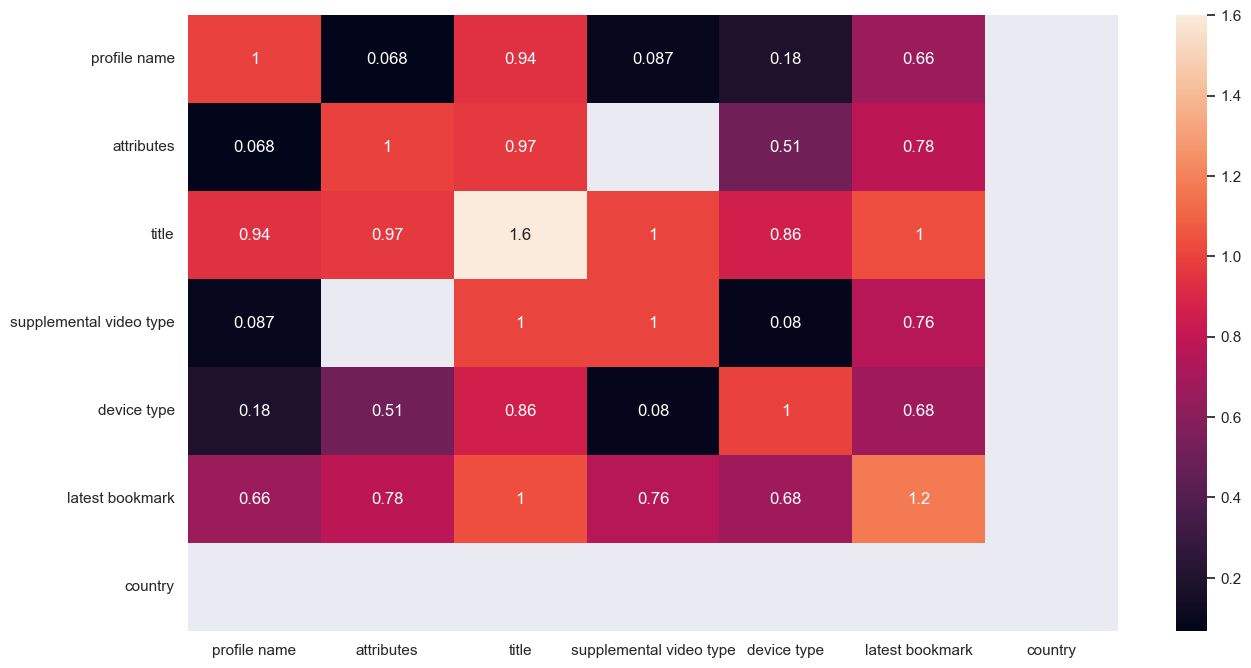

In [58]:
#gráfico de correlação das features

cat_features = cat_attributes

# dataframe with cramer-v 
cramer_v_dataframe = cramers_v_df(cat_features)

# create a mask
mask = np.zeros_like(cramer_v_dataframe, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# display heatmap
plt.subplots(figsize=(15, 8))
sns.heatmap( cramer_v_dataframe, annot = True);


# 5.0 Machine Learning Modelling

##### A estratégia foi efetivar um modelo de recomendação baseado no conteúdo de filmes e series (Content Based), no qual filmes/series com maior probabilidade de serem semelhantes são recomendados ao usuário. 

Foi utilizado o modelo TF-IDF (Term Frequency-Inverse Document Frequency), que adota um cálculo estatístico capaz de medir os termo mais relevantes para um tópico, analisando a frequência com que aparecem nos dados, em comparação à sua frequência em um conjunto maior de dados.

O cálculo faz uma ponderação de termos para entender a importância de palavras específicas nos dados fornecidos. Então, quanto maior for a frequência no documento (TF), maior será a importância do termo, e quanto maior a frequência no conjunto de dados (IDF), diminui o peso dos termos que ocorrem com muita frequência nesse conjunto e aumenta o peso dos termos que ocorrem raramente.


## 5.1 TfidfVectorizer - Score

In [59]:
TfidfVectorizer

sklearn.feature_extraction.text.TfidfVectorizer

## 5.2 Content Based Recommender

In [60]:
df5=df4.copy()

In [61]:
dados_modelo = df5[["title_2","descricao"]]
dados_modelo.head()

,title_2,descricao
0,Casais em Crise,4 casais que estão passando por problemas no r...
1,Sandman,"Após anos aprisionado, Morpheus, o Rei dos Son..."
2,1917,"Durante a Primeira Guerra Mundial, dois jovens..."
3,Spiderhead,"Em uma penitenciária de última geração, um det..."
4,Cobra Kai,Décadas depois da competição que mudou suas vi...


In [62]:
tfidf = TfidfVectorizer(stop_words="english")

In [63]:
#.values.astype('U') convert the dtype object to unicode string 
tfidf_matrix = tfidf.fit_transform(df5["descricao"].values.astype('U'))

In [64]:
tfidf_matrix.shape

(766, 5646)

In [65]:
#print("Palavras extraídas",tfidf.get_feature_names())

In [66]:
# Matriz esparsa
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names(), index=df5.title_2).sample(10, axis=1).sample(20, axis=0)


,decidida,kowalski,general,acontece,johnny,apocalipse,recrutados,através,gambini,letty
title_2,,,,,,,,,,
Heroes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Deslize,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gabriel - A vingança de um anjo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fuller House,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Megarrromântico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O Chefinho - De Volta aos Negócios,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Marvel - Luke Cage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Truques da Mente,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Perda Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

In [68]:
cosine_sim[0]

array([1.        , 0.06886945, 0.03851798, 0.04891127, 0.04205456,
       0.01449923, 0.0050945 , 0.02469908, 0.00586702, 0.02337067,
       0.00937326, 0.02201703, 0.02201248, 0.09241624, 0.01706374,
       0.03303855, 0.01061815, 0.00825194, 0.        , 0.02116029,
       0.03890843, 0.0209367 , 0.01139847, 0.04089734, 0.07526488,
       0.02106169, 0.07715662, 0.09052984, 0.04502962, 0.03649684,
       0.04270554, 0.00873523, 0.04204857, 0.02820852, 0.01581502,
       0.        , 0.04458643, 0.02084157, 0.02279226, 0.02490689,
       0.04445678, 0.        , 0.0378738 , 0.        , 0.06212007,
       0.02184323, 0.09186128, 0.02364545, 0.09237867, 0.        ,
       0.0421675 , 0.02082181, 0.03034795, 0.00446889, 0.        ,
       0.06893175, 0.02120466, 0.        , 0.04061789, 0.10596329,
       0.02970212, 0.03658514, 0.01852007, 0.01636622, 0.02411143,
       0.0326954 , 0.02508356, 0.0230562 , 0.02508978, 0.02888073,
       0.02070519, 0.06548654, 0.04398818, 0.0117839 , 0.06712

In [69]:
# cálculo das similaridades
cosine_sim_df = pd.DataFrame(cosine_sim, index=df5["title_2"], columns=df5["title_2"])
print("shape",cosine_sim_df.shape)
cosine_sim_df.sample(40, axis=1).round(2)

shape (766, 766)


title_2,Looper,Cosmos - Uma Odisseia do Espaço-Tempo,Batman - A Máscara do Fantasma,A Saga Viking,Capitã Nova,An Honest Liar,Coffee & Kareem,A Voz Suprema do Blues,Homens de honra,Arrested Development,...,Profissão de Risco,Uma Pousada de Presente,"Pablo Escobar, el patrón del mal",Moonlight - Sob a Luz do Luar,A Escolha,The Ranch,Tony Robbins,Klaus,Feliz Natal e Tal,Procura-se um amigo para o fim do mundo
title_2,,,,,,,,,,,,,,,,,,,,,
Casais em Crise,0.03,0.0,0.03,0.02,0.04,0.00,0.10,0.01,0.06,0.03,...,0.01,0.02,0.02,0.02,0.08,0.02,0.01,0.02,0.01,0.09
Sandman,0.05,0.0,0.02,0.01,0.05,0.00,0.02,0.01,0.03,0.02,...,0.00,0.01,0.01,0.01,0.00,0.04,0.01,0.01,0.01,0.05
1917,0.04,0.0,0.02,0.02,0.10,0.00,0.03,0.01,0.01,0.02,...,0.00,0.02,0.01,0.01,0.02,0.02,0.05,0.03,0.01,0.05
Spiderhead,0.03,0.0,0.04,0.04,0.06,0.00,0.05,0.03,0.02,0.02,...,0.01,0.02,0.02,0.01,0.01,0.03,0.01,0.04,0.09,0.08
Cobra Kai,0.05,0.0,0.05,0.09,0.04,0.00,0.05,0.00,0.03,0.01,...,0.00,0.00,0.04,0.01,0.00,0.00,0.01,0.00,0.00,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Marco Polo,0.01,0.0,0.01,0.01,0.02,0.00,0.00,0.03,0.00,0.00,...,0.02,0.00,0.05,0.02,0.00,0.01,0.00,0.01,0.00,0.02
Fábio Porchat - Fora do Normal,0.01,0.0,0.01,0.01,0.01,0.06,0.01,0.01,0.01,0.01,...,0.02,0.00,0.01,0.02,0.00,0.01,0.00,0.01,0.00,0.02
Será Que?,0.07,0.0,0.08,0.02,0.01,0.02,0.09,0.04,0.03,0.08,...,0.02,0.01,0.06,0.04,0.06,0.05,0.01,0.02,0.06,0.11


In [70]:
indices = pd.Series(df5.index, index = df5["title_2"]).drop_duplicates()


In [71]:
indices

title_2
Casais em Crise                        0
Sandman                                1
1917                                   2
Spiderhead                             3
Cobra Kai                              4
                                    ... 
Marco Polo                           761
Fábio Porchat - Fora do Normal       762
Será Que?                            763
Life Story                           764
As aventuras de Peabody e Sherman    765
Length: 766, dtype: int64

In [109]:
#Mostra pelo indice o nome de um filme do dataset
df5["title_2"][438]

'Croods, o Início'

In [105]:
# Recomendação com o Score

def get_recommendations(title, cosine_sim = cosine_sim):

    idx = indices[title]
    sim_scores = enumerate(cosine_sim[idx])
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    for i in sim_scores:
        print(i)
    movie_indices = [i[0] for i in sim_scores]
    print()
    print(dados_modelo["title_2"].iloc[movie_indices])
    
get_recommendations("Teen Wolf")


(438, 0.49070238242479736)
(237, 0.4225104101602683)
(755, 0.4165742138570538)
(211, 0.1300087135675186)
(575, 0.12403033989274516)
(638, 0.11132326824098744)
(719, 0.10589968437941166)
(574, 0.09445132653563665)
(615, 0.0884024669107746)
(290, 0.06705277413989104)

438            Croods, o Início
237           The Circle Brasil
755                    Riquinho
211              A Missy Errada
575                   TED Talks
638                    TEDTalks
719          Um Cupido no Natal
574    O Nascimento de Carlitos
615                   O lutador
290     Um Natal Quase Perfeito
Name: title_2, dtype: object


In [ ]:
import pickle

In [ ]:
pickle.dump(dados_modelo.to_dict(),open("modeloRecomendacao.pkl", "wb"))


In [ ]:
dados_modelo["title_2"].values

In [ ]:
pickle.dump(sim_scores,open("sim_scores.pkl", "wb"))